# Signature Detection

## Importing the dependencies

In [3]:
import numpy
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

In [4]:
path = r"G:\Users\GDriveAkshatRaj\Client Projects\Signature Detection\handwritten signatures\sample_Signature"
all_image = r"G:\Users\GDriveAkshatRaj\Client Projects\Signature Detection\handwritten signatures\Dataset_Signature_Final\Dataset"

## Laoding the dataset

`Use`
```
torchvision.datasets.ImageFolder
```

To preprocess the Image we used
```
from torchvision import  transforms
```

In [6]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=all_image,
                              transform=transform,)
dataloader= DataLoader(dataset, batch_size=32, shuffle=True)

## Define the Model

In [8]:
class SignatureCNN(nn.Module):
    def __init__(self):
        super(SignatureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        # we have 2 classes genuine and forge
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        # Flatten the Tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training the Model
- for training a model we'll use loss and optimizer
- Loss :- `Cross-Entropy`
- Optmizer :- `Adam`

In [10]:
model = SignatureCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss:{running_loss/len(dataloader):.4f}")

Epoch [1/10], Loss:0.0418
Epoch [1/10], Loss:0.7274
Epoch [1/10], Loss:0.8429
Epoch [1/10], Loss:0.9718
Epoch [1/10], Loss:1.0351
Epoch [1/10], Loss:1.0848
Epoch [1/10], Loss:1.1313
Epoch [1/10], Loss:1.1720
Epoch [1/10], Loss:1.2121
Epoch [1/10], Loss:1.2526
Epoch [1/10], Loss:1.2938
Epoch [1/10], Loss:1.3341
Epoch [1/10], Loss:1.3739
Epoch [1/10], Loss:1.4146
Epoch [1/10], Loss:1.4548
Epoch [1/10], Loss:1.4933
Epoch [1/10], Loss:1.5347
Epoch [2/10], Loss:0.0376
Epoch [2/10], Loss:0.0765
Epoch [2/10], Loss:0.1153
Epoch [2/10], Loss:0.1568
Epoch [2/10], Loss:0.1954
Epoch [2/10], Loss:0.2371
Epoch [2/10], Loss:0.2761
Epoch [2/10], Loss:0.3126
Epoch [2/10], Loss:0.3555
Epoch [2/10], Loss:0.3893
Epoch [2/10], Loss:0.4260
Epoch [2/10], Loss:0.4621
Epoch [2/10], Loss:0.4978
Epoch [2/10], Loss:0.5341
Epoch [2/10], Loss:0.5828
Epoch [2/10], Loss:0.6221
Epoch [2/10], Loss:0.6587
Epoch [3/10], Loss:0.0325
Epoch [3/10], Loss:0.0696
Epoch [3/10], Loss:0.1131
Epoch [3/10], Loss:0.1483
Epoch [3/10]

## Evaluating the Model

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct /total}")

Accuracy: 97.96672828096118


## Saving the Model
- So that we can use it later

In [14]:
torch.save(model.state_dict(), "final_signature_detection.pth")

## Testing on Individual Image
- Load the Image

In [16]:
image = Image.open("handwritten signatures/02102007.png")
image

FileNotFoundError: [Errno 2] No such file or directory: 'handwritten signatures/02102007.png'

In [17]:
def load_and_preprocess(path):
    transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
    # Load the image
    image = Image.open(path)
    # Apply preprocessing
    image = transform(image)
    # Add a batch dimension
    image = image.unsqueeze(0)
    return image

image = load_and_preprocess("handwritten signatures/real.png")
image

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

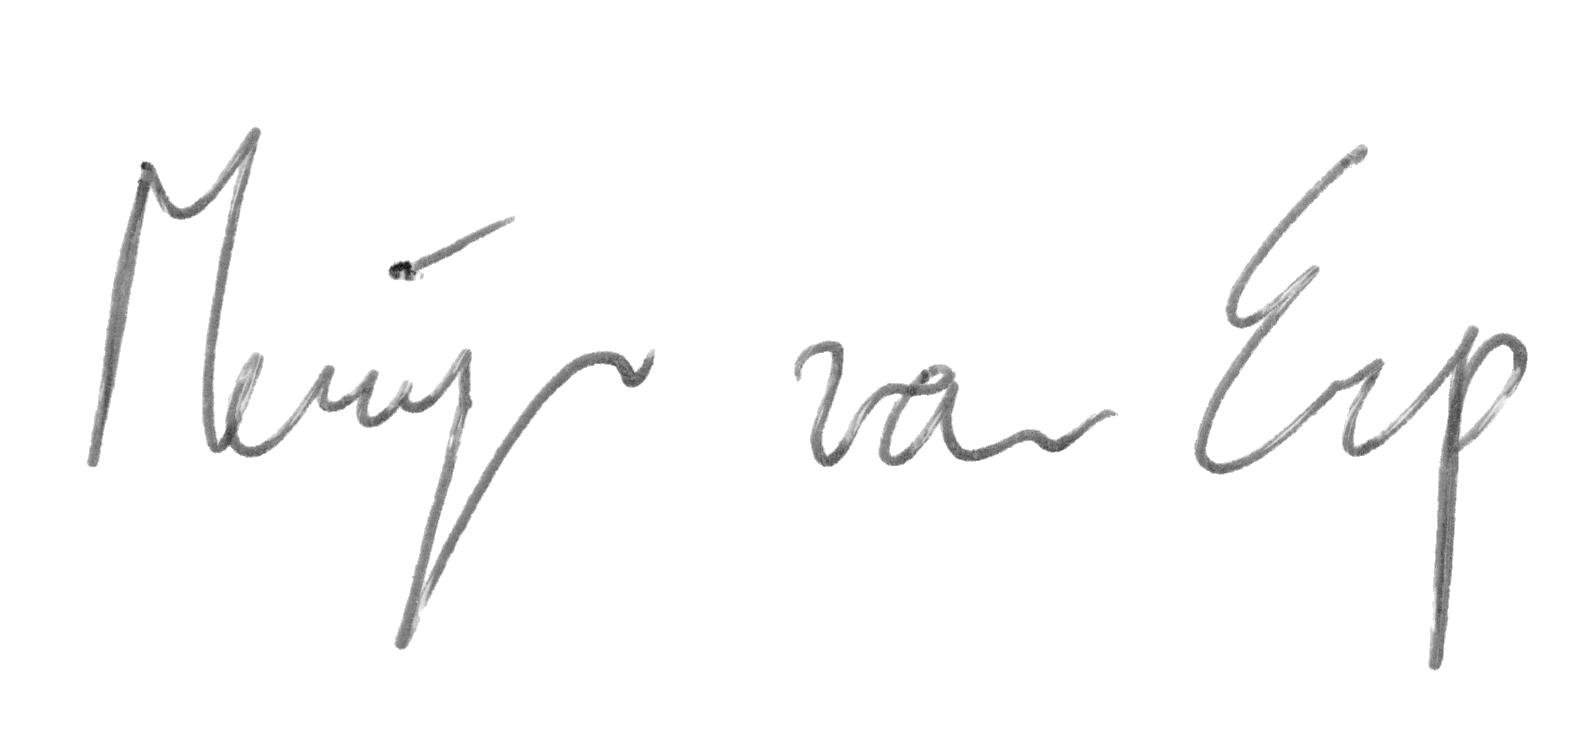

In [18]:
Image.open('handwritten signatures/real.png')

## Make predictions

In [21]:
def make_prediction(path):
    image = load_and_preprocess(path)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    
    classes = ['forged', 'genuine']
    return classes[predicted.item()]

In [22]:
from glob import glob

file = "handwritten signatures/*.png"
data = glob(file)
print(data)

for signature in data:
    img = Image.open(signature)
    img
    print(signature.split("\\")[-1].split(".")[0], make_prediction(signature))

['handwritten signatures\\02203010.png', 'handwritten signatures\\forge.png', 'handwritten signatures\\forge2.png', 'handwritten signatures\\forge3.png', 'handwritten signatures\\real.png', 'handwritten signatures\\real2.png', 'handwritten signatures\\real3.png']
02203010 forged
forge forged
forge2 forged
forge3 forged
real genuine
real2 genuine
real3 genuine
